<a href="https://www.kaggle.com/code/aisuko/image-classification-with-customise-model?scriptVersionId=166290407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

We will create a customise neural network with PyTorch to do the image classification tasks. First, we download the data and move them to the specific folders.


# Loading and Moving Data

We moving data to specific folder, like cats and dogs for more convenience.

In [1]:
%%capture
!unzip /kaggle/input/dogs-vs-cats/train.zip -d /kaggle/working
!unzip /kaggle/input/dogs-vs-cats/test1.zip -d /kaggle/working

In [2]:
import os

def data_status():
    for d_path, d_name, filenames in os.walk('/kaggle/working'):
        print(f"There are {len(d_name)} directories and {len(filenames)} images in '{d_path}'.")
data_status()

There are 3 directories and 0 images in '/kaggle/working'.
There are 0 directories and 0 images in '/kaggle/working/.virtual_documents'.
There are 0 directories and 12500 images in '/kaggle/working/test1'.
There are 0 directories and 25000 images in '/kaggle/working/train'.


In [3]:
import shutil

p_train='/kaggle/working/train/'
train_cat=p_train+'cat'
train_dog=p_train+'dog'

p_test='/kaggle/working/test/'
test_cat=p_test+'cat'
test_dog=p_test+'dog'

os.makedirs(train_cat, exist_ok=True)
os.makedirs(train_dog, exist_ok=True)
os.makedirs(test_cat, exist_ok=True)
os.makedirs(test_dog, exist_ok=True)



for file_train in os.listdir(p_train):
    if "dog" in file_train:
        shutil.move(f"{p_train}/{file_train}", train_dog)
    elif "cat" in file_train:
        shutil.move(f"{p_train}/{file_train}", train_cat) 
    else:
        pass

for file in os.listdir(train_dog)[:500]:
    shutil.move(f"{train_dog}/{file}", test_dog)
    
for file in os.listdir(train_cat)[:500]:
    shutil.move(f"{train_cat}/{file}", test_cat)

data_status()

There are 4 directories and 0 images in '/kaggle/working'.
There are 0 directories and 0 images in '/kaggle/working/.virtual_documents'.
There are 0 directories and 12500 images in '/kaggle/working/test1'.
There are 2 directories and 0 images in '/kaggle/working/test'.
There are 0 directories and 500 images in '/kaggle/working/test/dog'.
There are 0 directories and 500 images in '/kaggle/working/test/cat'.
There are 2 directories and 0 images in '/kaggle/working/train'.
There are 0 directories and 12000 images in '/kaggle/working/train/dog'.
There are 0 directories and 12000 images in '/kaggle/working/train/cat'.


Image shape: (500, 358, 3)


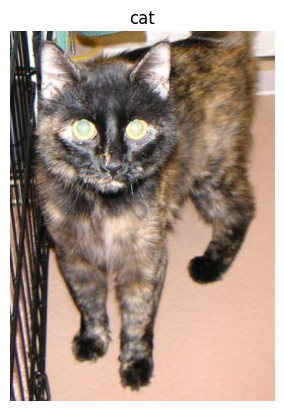

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    target_folder=target_dir+target_class
    random_image=random.sample(os.listdir(target_folder),1)
    img=mpimg.imread(target_folder+"/"+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image shape: {img.shape}") # show the shape of the image
    
    return img

img=view_random_image(target_dir=p_train, target_class="cat")

# Preprocess Data

Here we resize the image to the same size and batch them by using `transforms` from torchvision.

In [5]:
import torchvision
import torch.utils.data as data
from torchvision import transforms


batch_size=32

transform_img=transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

test_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train=torchvision.datasets.ImageFolder(root=p_train, transform=transform_img)
train_loader=data.DataLoader(train, batch_size=batch_size, shuffle=True)

test=torchvision.datasets.ImageFolder(root=p_test, transform=test_transforms)
test_loader=data.DataLoader(test, batch_size=batch_size, shuffle=True )

torch.Size([32, 3, 224, 224])
torch.Size([32])


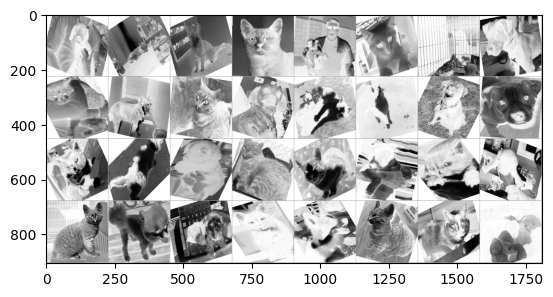

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, one_channel=False):
    if one_channel:
        img=img.mean(dim=0)
    img=img/2+0.5
    npimg=img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg,(1,2,0)))
    
images, labels=next(iter(train_loader))
print(images.shape)
print(labels.shape)

img_grid=torchvision.utils.make_grid(images)
imshow(img_grid, one_channel=True)

# Define the Model

In [7]:
import torch
import torch.nn as nn

torch.backends.cudnn.deterministic=True

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        
        # define convolutional layers
        
        self.conv1=nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2=nn.ReLU()
        # Since the pooling layer halves the size, the input image width and height must be divisible by 4 to avoid information loss during pooling. So our image should 224x224
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define fully connected layers
        self.fc1=nn.Linear(128*56*56,512) #Adjust the input size based on the image dimensions
        self.relu3=nn.ReLU()
        self.fc2=nn.Linear(512,2) # 2 output
    
    def forward(self, x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.pool1(out)
        
        out=self.conv2(out)
        out=self.relu2(out)
        out=self.pool2(out)
        out=out.view(out.size(0), -1) # flatten the output
        
        out=self.fc1(out)
        out=self.relu3(out)
        out=self.fc2(out)
        return out

classifier=ImageClassifier()

device='cuda'
classifier.to(device)

ImageClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

# Optimizing the Model Parameters

We need loss function and optimizer to train the model.

In [8]:
loss_fn=nn.CrossEntropyLoss()

learning_rate=1e-3
optimizer=torch.optim.SGD(classifier.parameters(), lr=learning_rate)

# Training

In [ ]:
# def accuracy(outputs, labels):
#     _, preds=torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds==labels).item()/len(preds))

def train_func(dataloader, model, loss_fn, optimizer):
    size=len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device), y.to(device)
        
        # compute prediction error
        pred=model(X)
        loss=loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch %100==0:
            loss,current=loss.item(), batch*len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
            
            
def test_func(dataloader, model):
    size=len(dataloader.dataset)
    model.eval()
    test_loss, correct=0,0
    with torch.no_grad():
        for X, y in dataloader:
            X,y =X.to(device), y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss/=size
    correct /=size
    print(f'Testing Score:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n')
            
epochs=10

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------')
    train_func(train_loader, classifier, loss_fn, optimizer)
    test_func(test_loader, classifier)
print("Done")

Epoch 1
-------------------
loss: 0.689045 [    0/24000]
loss: 0.685056 [ 3200/24000]
loss: 0.683603 [ 6400/24000]
loss: 0.625294 [ 9600/24000]
loss: 0.661074 [12800/24000]
loss: 0.691027 [16000/24000]
loss: 0.674980 [19200/24000]
loss: 0.650358 [22400/24000]
Testing Score:
 Accuracy: 64.1%, Avg loss: 0.020355

Epoch 2
-------------------
loss: 0.685859 [    0/24000]
loss: 0.678406 [ 3200/24000]


# Inference

In [ ]:
classes=[
    "cat",
    "dog"
]

classifier.eval()
x,y=test[0][0], test[0][1]
x=x.unsqueeze(0) # add new dimension to the top of the input tensor to fit the model input
print(x.shape)
print(y)

In [ ]:
x=x.to(device)
with torch.no_grad():
    pred=classifier(x)
    predicted, actual=classes[pred.argmax().item()], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Acknowledge

* https://www.kaggle.com/code/kurniazulda/cat-vs-dog
* https://www.kaggle.com/code/aisuko/fine-tuning-phi-2-with-qlora
* https://www.kaggle.com/code/aisuko/neural-network-for-image-classification